# Keras Tutorial #02
# Convolutional Neural Network with Keras

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

The previous tutorial showed that a simple linear model had about 91% classification accuracy for recognizing hand-written digits in the MNIST data-set.

In this tutorial we will implement a simple Convolutional Neural Network with Keras which has a classification accuracy of about 99%, or more if you make some of the suggested exercises.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image. This makes the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. This in turn makes the Convolutional Networks faster to train.

You should be familiar with basic linear algebra, Python and the Jupyter Notebook editor. Beginners to Keras may also want to study the first tutorial before proceeding to this one.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.

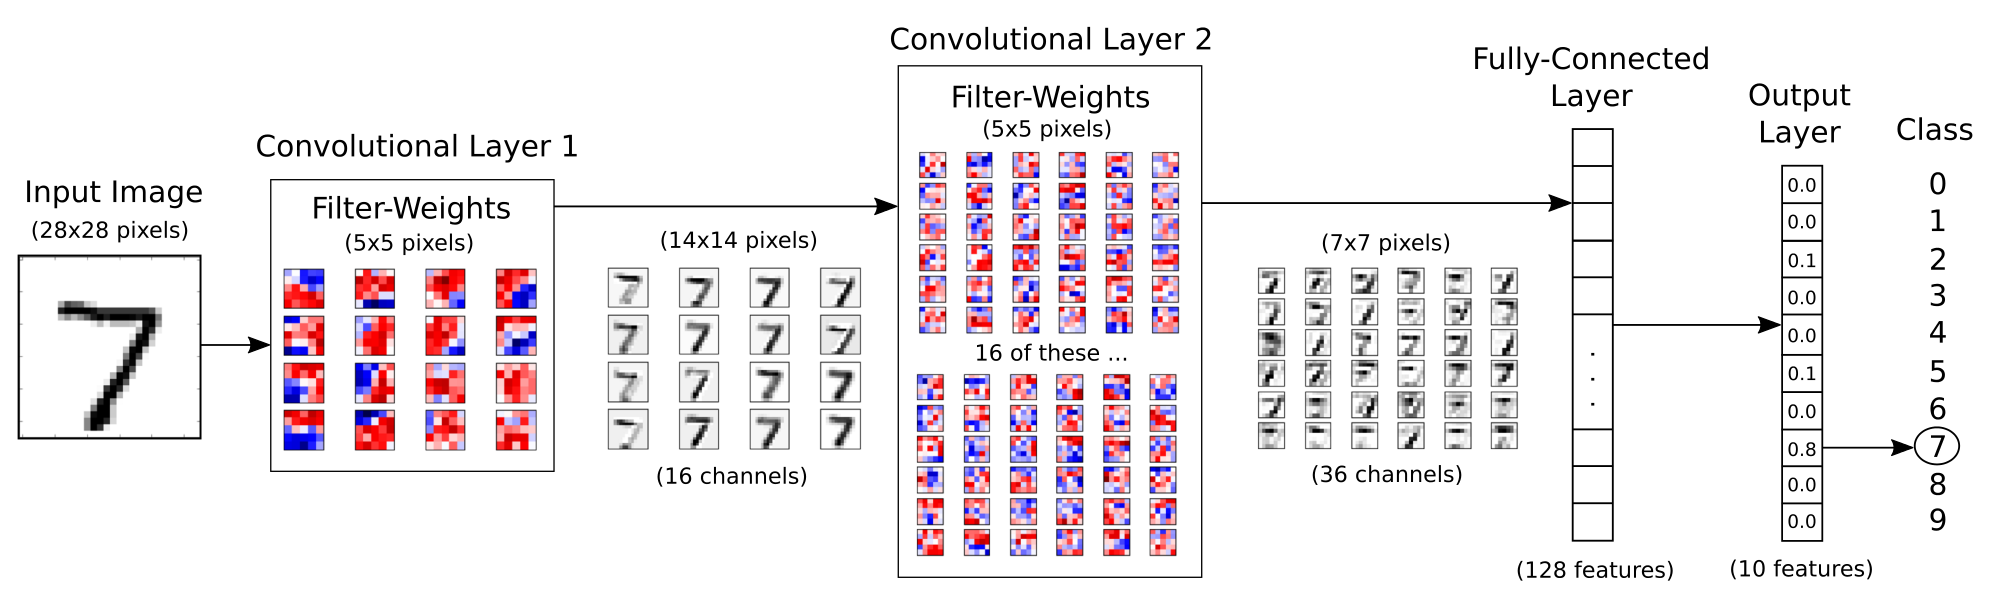

In [1]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also down-sampled so the image resolution is decreased from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are down-sampled again to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this Notebook.

Note that the computation in Keras is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in Keras.

## Convolutional Layer

The following chart shows the basic idea of processing an image in the first convolutional layer. The input image depicts the number 7 and four copies of the image are shown here, so we can see more clearly how the filter is being moved to different positions of the image. For each position of the filter, the dot-product is being calculated between the filter and the image pixels under the filter, which results in a single pixel in the output image. So moving the filter across the entire input image results in a new image being generated.

The red filter-weights means that the filter has a positive reaction to black pixels in the input image, while blue pixels means the filter has a negative reaction to black pixels.

In this case it appears that the filter recognizes the horizontal line of the 7-digit, as can be seen from its stronger reaction to that line in the output image.

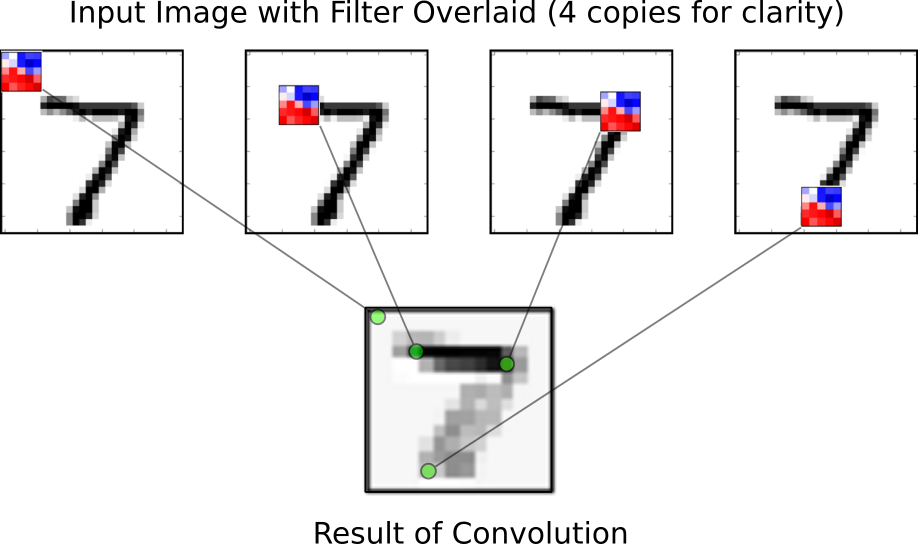

In [2]:
Image('images/02_convolution.png')

The step-size for moving the filter across the input is called the stride. There is a stride for moving the filter horizontally (x-axis) and another stride for moving vertically (y-axis).

In the source-code below, the stride is set to 1 in both directions, which means the filter starts in the upper left corner of the input image and is being moved 1 pixel to the right in each step. When the filter reaches the end of the image to the right, then the filter is moved back to the left side and 1 pixel down the image. This continues until the filter has reached the lower right corner of the input image and the entire output image has been generated.

When the filter reaches the end of the right-side as well as the bottom of the input image, then it can be padded with zeroes (white pixels). This causes the output image to be of the exact same dimension as the input image.

Furthermore, the output of the convolution may be passed through a so-called Rectified Linear Unit (ReLU), which merely ensures that the output is positive because negative values are set to zero. The output may also be down-sampled by so-called max-pooling, which considers small windows of 2x2 pixels and only keeps the largest of those pixels. This halves the resolution of the input image e.g. from 28x28 to 14x14 pixels.

Note that the second convolutional layer is more complicated because it takes 16 input channels. We want a separate filter for each input channel, so we need 16 filters instead of just one. Furthermore, we want 36 output channels from the second convolutional layer, so in total we need 16 x 36 = 576 filters for the second convolutional layer. It can be a bit challenging to understand how this works.

## Imports

In [3]:
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras import backend as K
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import math
import time
from datetime import timedelta

Using TensorFlow backend.


This was developed using Python 3.5.2 (Anaconda) and Keras version:

In [4]:
keras.__version__

'2.0.0'

## Configuration of Neural Network

The configuration of the Convolutional Neural Network is defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

In [5]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [6]:
(train_images, train_labels_cls), (test_images, test_labels_cls) = mnist.load_data()
(train_images.shape, train_labels_cls.shape), (test_images.shape, test_labels_cls.shape) 


(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets.

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(train_labels_cls)))
print("- Test-set:\t\t{}".format(len(test_labels_cls)))

Size of:
- Training-set:		60000
- Test-set:		10000


When we loaded the data we named it `test_labels_cls` given their classes was represented by a single number . We need the classes as single numbers for various comparisons and performance measures but we need to convert the data-set into One-Hot encoding in order to feed it to our output layer. This means we want to convert the labels from a single number to a vector whose length equals the number of possible classes. We want all elements of the vector to be zero except for the $i$'th element which is one and means the class is $i$. For example, the single number first five images in the test-set are:

In [8]:
test_labels = np_utils.to_categorical(test_labels_cls)
train_labels = np_utils.to_categorical(train_labels_cls)
test_labels_cls[0:5], test_labels[0:5]

(array([7, 2, 1, 0, 4], dtype=uint8),
 array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]]))

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [9]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In order to feed the images to our keras model they must be flatten down from an `img_shape` of 28×28 pixels array to an `img_size_flat` of 784 pixels vector.

In [10]:
train_images = train_images.reshape(train_images.shape[0], img_size, img_size, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], img_size, img_size, 1).astype('float32')

Another data requirment for our keras model is to normalize inputs from 0-255 to 0-1

In [11]:
train_images = train_images / 255.0
test_images = test_images / 255.0

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [12]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

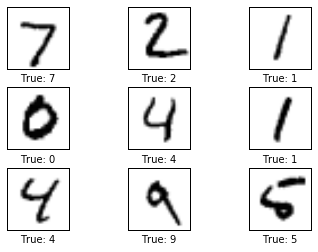

In [13]:
# Get the first images from the test-set.
images = test_images[0:9]

# Get the true classes for those images.
cls_true = test_labels_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Keras Model

The entire purpose of Keras is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. Keras can be more efficient than NumPy because it can use TensorFlow or Torch which know the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time. In this notebook we will use Keras powered by TensorFlow. 

Keras can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

Keras can use the TensorFlow framework to take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A Keras model consists of the following parts which will be detailed below:

* A model which is essentially just a mathematical function that fits some output given the input variables and the model variables.
* A stack of layers that are going to be fitted so as to make the model perform better.
* A compiled model with: 
    * A loss measure that can be used to guide the optimization of the variables 
    * An optimization method which updates the variables of the model.
    
In addition, the Keras may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

##  Model Selection

There are two types of models available in Keras: the `Sequential` model for simple linear architectures and the `Model` class with functional API for more complex architectures.
In this case let's intance a `Sequential` Model where we can linearly add a stack of layer.

In [14]:
model = Sequential()

## Adding Layers

### 1st Convolutional Layer 

Create the first convolutional layer. It takes `x_image` as input and creates `num_filters1` different filters, each having width and height equal to `filter_size1`. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

This `Conv2D` layer creates a new convolutional layer in the computational graph for Keras. Nothing is actually calculated here, we are just adding the layer to the Keras graph.

In [15]:
model.add(Conv2D(filters=num_filters1, kernel_size=filter_size1, 
                 input_shape=(img_size, img_size, 1), 
                 padding='same', activation='relu'),)

It is assumed that the input is a 3-dim tensor with the following dimensions:

2. Y-axis of each image.
3. X-axis of each image.
4. Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.

In [16]:
(img_size, img_size, 1) # Input Shape

(28, 28, 1)

The output is another 4-dim tensor with the following dimensions:

1. `None` means that an unspecified dimension in Keras
2. Y-axis of each image.
3. X-axis of each image. Ditto.
4. Channels produced by the convolutional filters.

In [17]:
model.layers[0].output_shape # Output Shape

(None, 28, 28, 16)

### 1st MaxPool Layer

Use pooling to down-sample the image resolution.
This is 2x2 max-pooling, which means that we consider 2x2 windows and select the largest value in each window. Then we move 2 pixels to the next window.

In [18]:
model.add(MaxPooling2D(pool_size=(2, 2)))

The output is another 4-dim tensor with the following dimensions:

1. Image number, same as input.
2. Y-axis of each image, the height and width of the input images is divided by 2.
3. X-axis of each image, the height and width of the input images is divided by 2.
4. Channels produced by the convolutional filters.

Check the shape of the tensor that will be output by the convolutional layer. It is (None, 14, 14, 16) which means that there is an arbitrary number of images (this is the None), each image is 14 pixels wide and 14 pixels high, and there are 16 different channels, one channel for each of the filters.

In [19]:
model.layers[1].output_shape

(None, 14, 14, 16)

### 2nd Convolutional Layer

Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [20]:
model.add(Conv2D(filters=num_filters2, kernel_size=filter_size2, 
                 strides=(1, 1), padding='same', activation='relu'))

### 2nd MaxPool Layer

Use pooling to down-sample the image resolution.
This is 2x2 max-pooling, which means that we consider 2x2 windows and select the largest value in each window. Then we move 2 pixels to the next window.

Check the shape of the tensor that will be output from this convolutional layer. The shape is (None, 7, 7, 36) where the None again means that there is an arbitrary number of images, with each image having width and height of 7 pixels, and there are 36 channels, one for each filter.

In [21]:
model.add(MaxPooling2D(pool_size=(2, 2)))
model.layers[3].output_shape

(None, 7, 7, 36)

In [22]:
model.layers

### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [23]:
model.add(Flatten())

Check that the tensors now have shape (None, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7 x 7 x 36.

In [24]:
layer_fc1 = model.layers[4]
layer_fc1.output_shape

(None, 1764)

### Fully-Connected Layer 1

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is `fc_size`. ReLU is used so we can learn non-linear relations.

In [25]:
model.add(Dense(fc_size, activation='relu'))


Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and `fc_size` == 128.

In [26]:
model.layers[-1].output_shape

(None, 128)

### Fully-Connected Layer 2

Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [27]:
model.add(Dense(num_classes))

In [28]:
model.layers[-1].output_shape

(None, 10)

### Predicted Class

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [29]:
model.add(Activation('softmax'))

### Model Summary

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               225920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
__________

## Model Compilation

### Loss Function

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model to the desired output.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

Keras has a built-in function for calculating the cross-entropy: `loss='categorical_crossentropy'`. 

Note `loss='categorical_crossentropy'` does not only calculate the cross-entropy for each of the image classification in order to measure how well the model performs on each image individually.  `loss='categorical_crossentropy'` also takes the average of the cross-entropy for all the image classifications in order to use the cross-entropy to guide the optimization of the model's variables with a single scalar value, 

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the Adam optimizer which is an advanced form of Gradient Descent with `optimizer='adam'`.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the Keras  mode for later execution.

### Performance Measures

We need a few more performance measures to display the progress to the user, let's display the accuracy with `metrics=['accuracy']`

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Helper-functions to show performance

In [32]:
def print_accuracy():
    # Use Keras to compute the accuracy.
    acc = model.evaluate(test_images, test_labels)
    
    # Print the accuracy.
    print("\nAccuracy on test-set:: %.2f%%" % (acc[1]*100))

Function for printing the classification accuracy on the test-set.

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [33]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = test_labels_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [34]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = test_labels_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [35]:
pred = model.predict(test_images[0:200])

In [36]:
# Split the test-set into smaller batches of this size.
test_batch_size = 10000

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(test_images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = test_images[i:j, :]

        # Get the associated labels.
        labels = test_labels[i:j, :]

        # Calculate the predicted class using Keras.
        pred = model.predict(test_images)
        cls_pred[i:j] = np.array([label.argmax() for label in pred])

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Let's round the decimal number prediction to obtain a 1 hot representation
    pred_one_hot = [np.round(x) for x in pred]
    
    # Lets convert the one-hot representation to single numbers
    cls_pred = np.array([label.argmax() for label in pred_one_hot])

    # Get the correct classifications for the test-set.
    correct = cls_pred == test_labels_cls

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Keras Fitting

### Performance before any optimization

The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [37]:
len(pred)

200

In [38]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (980 / 10000)


There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [39]:
train_batch_size = 64

## Performance after fitting 1 batch 5 epochs

The classification accuracy does not improve from just 1 batch 1 epochs, because the learning-rate for the optimizer is set very low.

In [40]:
# Let's contrain our dataset to 1 batch
one_batch =  train_images[0:train_batch_size].shape
one_batch

(64, 28, 28, 1)

In [41]:
h = model.fit(x=train_images[:train_batch_size],  
              y=train_labels[:train_batch_size], epochs=5, 
              batch_size=train_batch_size, verbose=1,
              validation_data=(test_images[:train_batch_size],
                               test_labels[:train_batch_size]));

Train on 64 samples, validate on 64 samples
Epoch 1/5
64/64 [==============================] - 0s - loss: 2.3014 - acc: 0.1250 - val_loss: 2.2670 - val_acc: 0.2031
Epoch 2/5
64/64 [==============================] - 0s - loss: 2.2251 - acc: 0.3281 - val_loss: 2.2135 - val_acc: 0.2969
Epoch 3/5
64/64 [==============================] - 0s - loss: 2.1428 - acc: 0.4688 - val_loss: 2.1526 - val_acc: 0.4062
Epoch 4/5
64/64 [==============================] - 0s - loss: 2.0451 - acc: 0.5156 - val_loss: 2.0829 - val_acc: 0.5000
Epoch 5/5
64/64 [==============================] - 0s - loss: 1.9322 - acc: 0.6094 - val_loss: 2.0014 - val_acc: 0.5625


In [42]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (980 / 10000)


## Performance after fitting 1 batch 10 epoch

The classification accuracy does not improve from just 1 batch 1 epoch, because the learning-rate for the optimizer is set very low.

In [43]:
h = model.fit(x=train_images[:train_batch_size],  
              y=train_labels[:train_batch_size], epochs=5, 
              batch_size=train_batch_size, verbose=1,
              validation_data=(test_images[:train_batch_size],
                               test_labels[:train_batch_size]));

Train on 64 samples, validate on 64 samples
Epoch 1/5
64/64 [==============================] - 0s - loss: 1.8038 - acc: 0.6250 - val_loss: 1.9039 - val_acc: 0.5469
Epoch 2/5
64/64 [==============================] - 0s - loss: 1.6561 - acc: 0.6406 - val_loss: 1.7876 - val_acc: 0.5625
Epoch 3/5
64/64 [==============================] - 0s - loss: 1.4908 - acc: 0.6562 - val_loss: 1.6564 - val_acc: 0.5469
Epoch 4/5
64/64 [==============================] - 0s - loss: 1.3122 - acc: 0.6875 - val_loss: 1.5262 - val_acc: 0.5938
Epoch 5/5
64/64 [==============================] - 0s - loss: 1.1299 - acc: 0.7969 - val_loss: 1.4037 - val_acc: 0.6094


In [44]:
print_test_accuracy()

Accuracy on Test-Set: 24.3% (2433 / 10000)


## Performance after 1 epochs of the full training set

1 epochs of the full training set, the model has greatly increased its accuracy on the test-set to more than 98%.

In [45]:
h = model.fit(x=train_images,  
              y=train_labels, epochs=1, 
              batch_size=train_batch_size, verbose=1,
              validation_data=(test_images,
                               test_labels));

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 4s - loss: 0.1272 - acc: 0.9603 - val_loss: 0.0432 - val_acc: 0.9867


In [46]:
print_test_accuracy()

Accuracy on Test-Set: 98.5% (9850 / 10000)


Function for performing a number of fitting iterations so as to gradually display the model accuracy. At each epoch, after all the batches of data from the training-set are fitted Keras executes the fit using those training samples a callback which prints the progress every 100 iterations.

## Performance after 2 epochs of the full training set

After 100 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 98.5%.

In [47]:
model.fit(x=train_images, y=train_labels, 
          epochs=1, batch_size=train_batch_size, verbose=1,
          validation_data=(test_images,test_labels));

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 4s - loss: 0.0443 - acc: 0.9857 - val_loss: 0.0366 - val_acc: 0.9877


Accuracy on Test-Set: 98.7% (9870 / 10000)
Example errors:


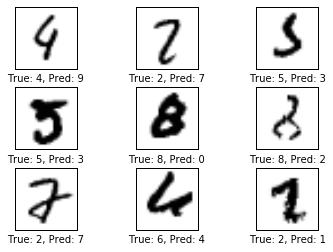

In [48]:
print_test_accuracy(show_example_errors=True)

## Performance after 10 optimization iterations

After 100 optimization iterations, the model has a classification accuracy on the test-set of about 99%.

In [49]:
# Run the optimizer using a batch of training data.
model.fit(x=train_images,  y=train_labels, 
          epochs= 10, batch_size=train_batch_size, verbose=1, 
          validation_data=(test_images, test_labels));

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s - loss: 0.0309 - acc: 0.9902 - val_loss: 0.0317 - val_acc: 0.9887
Epoch 2/10
60000/60000 [==============================] - 4s - loss: 0.0229 - acc: 0.9926 - val_loss: 0.0300 - val_acc: 0.9902
Epoch 3/10
60000/60000 [==============================] - 4s - loss: 0.0171 - acc: 0.9946 - val_loss: 0.0279 - val_acc: 0.9908
Epoch 4/10
60000/60000 [==============================] - 4s - loss: 0.0144 - acc: 0.9955 - val_loss: 0.0304 - val_acc: 0.9904
Epoch 5/10
60000/60000 [==============================] - 4s - loss: 0.0112 - acc: 0.9963 - val_loss: 0.0251 - val_acc: 0.9923
Epoch 6/10
60000/60000 [==============================] - 4s - loss: 0.0098 - acc: 0.9966 - val_loss: 0.0288 - val_acc: 0.9904
Epoch 7/10
60000/60000 [==============================] - 4s - loss: 0.0083 - acc: 0.9972 - val_loss: 0.0339 - val_acc: 0.9910
Epoch 8/10
60000/60000 [==============================] - 4s 

Accuracy on Test-Set: 99.2% (9917 / 10000)
Example errors:


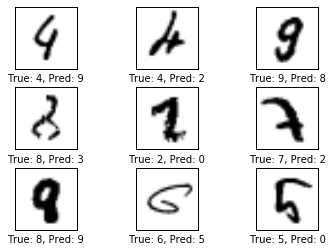

Confusion Matrix:
[[ 976    0    0    1    0    0    1    0    2    0]
 [   0 1132    0    1    0    1    1    0    0    0]
 [   2    0 1028    0    0    0    0    1    1    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    0    1    0  974    0    1    0    1    5]
 [   1    0    0    6    0  883    1    0    1    0]
 [   4    3    0    0    3    1  945    0    2    0]
 [   1    2    8    1    0    0    0 1011    1    4]
 [   1    0    1    2    0    0    0    0  968    2]
 [   3    0    1    2    3    4    0    0    2  994]]


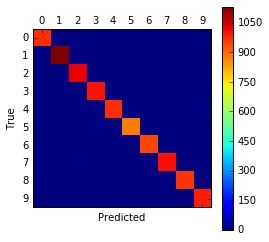

In [50]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Visualization of Weights and Layers

In trying to understand why the convolutional neural network can recognize handwritten digits, we will now visualize the weights of the convolutional filters and the resulting output images.

### Helper-function for plotting convolutional weights

In [51]:
def plot_conv_weights(layer_index, input_channel=0):
    # Assume weights are Keras ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from Keras.
    # A feed-dict is not necessary because nothing is calculated.
    w = model.layers[layer_index].get_weights()[0]
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(int(num_grids), int(num_grids))

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [ ]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Images

Helper-function for plotting an image.

In [54]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

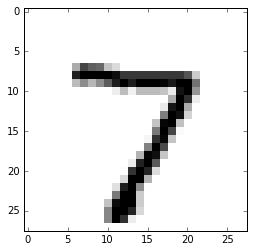

In [55]:
image1 = test_images[0]
plot_image(image1)

Plot another example image from the test-set.

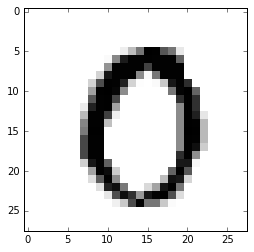

In [56]:
image2 = test_images[13]
plot_image(image2)

### Convolution Layer 1

Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

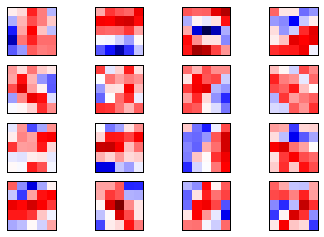

In [57]:
w = plot_conv_weights(layer_index=0)

In [58]:
def plot_conv_layer(layer_index, images):
    # Assume layer is a Keras op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    
    # input placeholder
    inp = model.input
    # all layer outputs
    outputs = [layer.output for layer in model.layers]
     # evaluation functions
    functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    # getting layer outputs
    layer_outs = [func([images, 1.]) for func in functors]
    values = layer_outs[layer_index][0]
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]
    
    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(int(num_grids), int(num_grids))

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

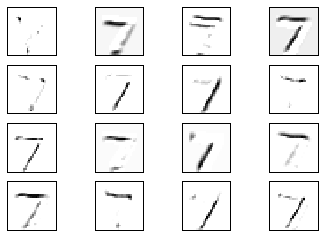

In [59]:
plot_conv_layer(layer_index=0, images=test_images[0:1])

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to 14 x 14 pixels which is half the resolution of the original input image.

The following images are the results of applying the convolutional filters to the second image.

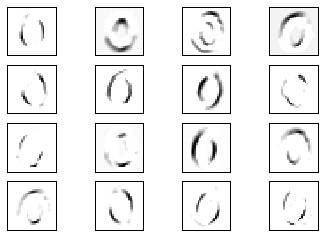

In [60]:
plot_conv_layer(layer_index=0, images=test_images[13:14])

It is difficult to see from these images what the purpose of the convolutional filters might be. It appears that they have merely created several variations of the input image, as if light was shining from different angles and casting shadows in the image.

### Convolution Layer 2

Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

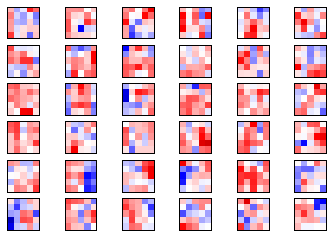

In [61]:
plot_conv_weights(layer_index=2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel. 

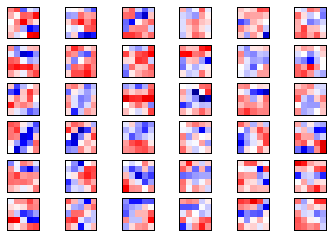

In [62]:
plot_conv_weights(layer_index=2, input_channel=1)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled yet again to 7 x 7 pixels which is half the resolution of the images from the first conv-layer.

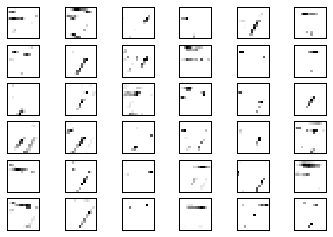

In [63]:
plot_conv_layer(layer_index=2, images=test_images[0:1])

And these are the results of applying the filter-weights to the second image.

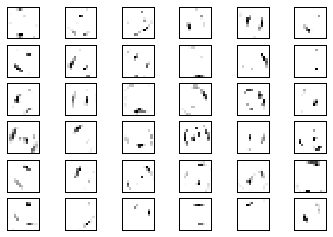

In [64]:
plot_conv_layer(layer_index=2, images=test_images[13:14])

From these images, it looks like the second convolutional layer might detect lines and patterns in the input images, which are less sensitive to local variations in the original input images.

These images are then flattened and input to the fully-connected layer, but that is not shown here.

## Conclusion

We have seen that a Convolutional Neural Network works much better at recognizing hand-written digits than the simple linear model in Tutorial #01. The Convolutional Network gets a classification accuracy of about 99%, or even more if you make some adjustments, compared to only 91% for the simple linear model.

However, the Convolutional Network is also much more complicated to implement, and it is not obvious from looking at the filter-weights why it works and why it sometimes fails.

So we would like an easier way to program Convolutional Neural Networks and we would also like a better way of visualizing their inner workings.

## Exercises

These are a few suggestions for exercises that may help improve your skills with Keras. It is important to get hands-on experience with Keras in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Do you get the exact same results if you run the Notebook multiple times without changing any parameters? What are the sources of randomness?
* Run another 10,000 optimization iterations. Are the results better?
* Change the learning-rate for the optimizer.
* Change the configuration of the layers, such as the number of convolutional filters, the size of those filters, the number of neurons in the fully-connected layer, etc.
* Add a so-called drop-out layer after the fully-connected layer. Note that the drop-out probability should be zero when calculating the classification accuracy, so you will need a placeholder variable for this probability.
* Change the order of ReLU and max-pooling in the convolutional layer. Does it calculate the same thing? What is the fastest way of computing it? How many calculations are saved? Does it also work for Sigmoid-functions and average-pooling?
* Add one or more convolutional and fully-connected layers. Does it help performance?
* What is the smallest possible configuration that still gives good results?
* Try using ReLU in the last fully-connected layer. Does the performance change? Why?
* Try not using pooling in the convolutional layers. Does it change the classification accuracy and training time?
* Try using a 2x2 stride in the convolution instead of max-pooling? What is the difference?
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.